In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import os
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [5]:
from google.colab import files

uploaded = files.upload()

Saving 10comm-decarlo.jpg to 10comm-decarlo.jpg
Saving 0805personali01.jpg to 0805personali01.jpg
Saving 1198_0_861.jpg to 1198_0_861.jpg
Saving 2382SJ8.jpg to 2382SJ8.jpg
Saving 57635685_d41c98f8ca.jpg to 57635685_d41c98f8ca.jpg
Saving 92053278_be61a225d2.jpg to 92053278_be61a225d2.jpg
Saving 96063776_bdb3617b64.jpg to 96063776_bdb3617b64.jpg
Saving 97308305_4b737d0873.jpg to 97308305_4b737d0873.jpg
Saving 110276240_bec305da91.jpg to 110276240_bec305da91.jpg
Saving 137341995_e7c48e9a75.jpg to 137341995_e7c48e9a75.jpg
Saving 144044282_87cf3ff76e.jpg to 144044282_87cf3ff76e.jpg
Saving 152601997_ec6429a43c.jpg to 152601997_ec6429a43c.jpg
Saving 252418361_440b75751b.jpg to 252418361_440b75751b.jpg
Saving 262007783_943bbcf613.jpg to 262007783_943bbcf613.jpg
Saving 297448785_b2dda4b2c0.jpg to 297448785_b2dda4b2c0.jpg
Saving 299733036_fff5ea6f8e.jpg to 299733036_fff5ea6f8e.jpg
Saving 303808204_1f744bc407.jpg to 303808204_1f744bc407.jpg
Saving 343583208_e986824d77.jpg to 343583208_e986824d77.

In [7]:
landmarks_frame = pd.read_csv("face_landmarks.csv")
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [12]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
img_name

landmarks = landmarks_frame.iloc[n,1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1,2)
landmarks[:4]

array([[32., 65.],
       [33., 76.],
       [34., 86.],
       [34., 97.]])

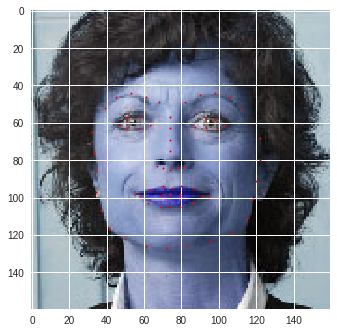

In [19]:
# lets write a function to show all the landmarks
import cv2 as cv2

def show_landmarks(image,landmarks):
  plt.imshow(image)
  plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c = 'r')
  plt.pause(0.001)

plt.figure()
show_landmarks(cv2.imread(img_name), landmarks)
plt.show()

In [0]:
# make a custom dataset class for loading data

class FaceLandmarksDataset(Dataset):
  
  def __init__(self, csv_file, transform=None):
    
    self.landmarks_frame = pd.read_csv(csv_file)
    self.transform = transform
    
  def __len__(self):
    return (len(self.landmarks_frame))
  
  def __getitem__(self,idx):
    img_name = self.landmarks_frame.iloc[idx,0]
    
    image = cv2.imread(img_name)
    landmarks = self.landmarks_frame.iloc[idx,1:].as_matrix()
    landmarks = landmarks.astype('float').reshape(-1,2)
    sample = {'image': image, 'landmarks': landmarks}
    
    if self.transform:
      sample = self.transform(sample)
    
    return sample


In [0]:
face_dataset = FaceLandmarksDataset('face_landmarks.csv')

0 (324, 215, 3) (68, 2)


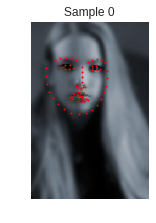

1 (500, 333, 3) (68, 2)


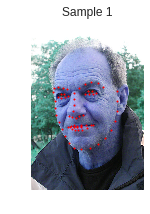

2 (250, 258, 3) (68, 2)


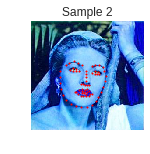

3 (434, 290, 3) (68, 2)


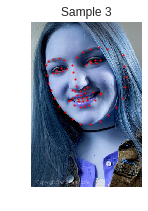

4 (828, 630, 3) (68, 2)


ValueError: ignored

In [28]:
fig = plt.figure()

for i in range(len(face_dataset)):
  sample = face_dataset[i]
  
  print(i, sample['image'].shape, sample['landmarks'].shape)
  
  ax = plt.subplot(1,4,i+1)
  plt.tight_layout()
  ax.set_title ('Sample {}'.format(i))
  ax.axis('off')
  
  show_landmarks(**sample)
  
  if i==4:
    plt.show()
    break

In [0]:
# now we can see that all images of different sizes so applying different transforms
class Rescale(object):
   
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

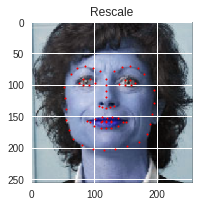

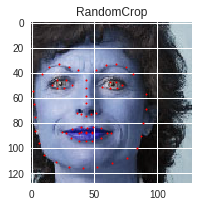

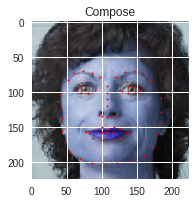

In [47]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [0]:
# iterating through the dataset

transformed_dataset = FaceLandmarksDataset(csv_file = "face_landmarks.csv", transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))

In [50]:
for i in range(len(transformed_dataset)):
  sample = transformed_dataset[i]
  
  print(i, sample['image'].size(), sample['landmarks'].size())
  
  if i == 3:
    break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


Batching the data

Shuffling the data

Load the data in parallel using multiprocessing workers.

All tis can be done with torch.utils.data.DataLoader

In [0]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)